In [1]:
%%time
import os

import pandas as pd
from pandas.core.groupby import DataFrameGroupBy
from dask.diagnostics import ProgressBar
from tqdm.dask import TqdmCallback

from shared_code.utility.schemas.pyarrow_schema import schema
from shared_code.utility.spark.set_environ import set_azure_env

cb = TqdmCallback(desc="global")
cb.register()

set_azure_env()

from shared_code.utility.storage.azure_file_storage import AzureFileStorageAdapter

file_system = AzureFileStorageAdapter('data').get_file_storage()

CPU times: total: 1.86 s
Wall time: 10.5 s


In [2]:
def filter_on_existing_thumbnail_path(x: object) -> bool:
	try:
		path = x['thumbnail_path']
		return os.path.exists(path)
	except:
		return False

In [3]:
def get_image_bytes(x: object) -> object:
	try:
		path = x['path']
		data = open(path, 'rb').read()
		return data
	except:
		return None

In [4]:
%%time
extant_data = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(extant_data)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,11j03l0,celebrities,Jzk592,Gal Gadot,arafed image of a woman in a scarf around her ...,937ab8bcc41f39055217d64c38a447d9,/r/celebrities/comments/11j03l0/gal_gadot/,https://i.redd.it/s1ik1llgqve81.jpg,937ab8bcc41f39055217d64c38a447d9.jpg,D:\data\images\celebrities\937ab8bcc41f3905521...,D:\data\images\celebrities\thumbnail\937ab8bcc...,True,False
21742,11ns444,celebrities,ConnectionOk8413,Amy Adams,a woman in a black leather jacket and tie dyes...,641520ae16f4aabd494172f80267ebed,/r/celebrities/comments/11ns444/amy_adams/,https://i.redd.it/niul7blwjxma1.jpg,641520ae16f4aabd494172f80267ebed.jpg,D:\data\images\celebrities\641520ae16f4aabd494...,D:\data\images\celebrities\thumbnail\641520ae1...,True,False
21743,11nrqmo,celebrities,Ahenze85,Kate Beckinsale,arafed image of a woman sitting in a chair wit...,85ea0e7a20268adaaefd8cbc31868647,/r/celebrities/comments/11nrqmo/kate_beckinsale/,https://i.redd.it/qihkgqruyyma1.jpg,85ea0e7a20268adaaefd8cbc31868647.jpg,D:\data\images\celebrities\85ea0e7a20268adaaef...,D:\data\images\celebrities\thumbnail\85ea0e7a2...,True,False
21744,11nmtns,celebrities,mikere24,Madelaine Petsch,a woman in a sheer - lined dress with a sheer ...,296b6a7b159560e2811f41a4d659050e,/r/celebrities/comments/11nmtns/madelaine_petsch/,https://i.redd.it/kifsl6yywxma1.jpg,296b6a7b159560e2811f41a4d659050e.jpg,D:\data\images\celebrities\296b6a7b159560e2811...,D:\data\images\celebrities\thumbnail\296b6a7b1...,True,False


CPU times: total: 328 ms
Wall time: 1.95 s


CPU times: total: 2.92 s
Wall time: 22.2 s


<Axes: xlabel='subreddit'>

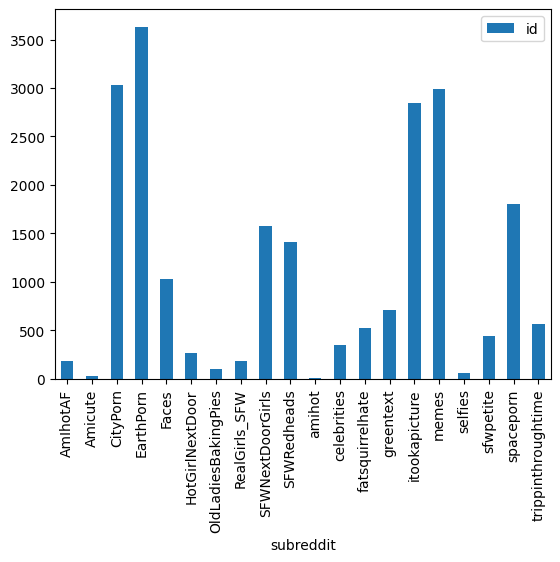

In [5]:
%%time
temp = extant_data.copy()
temp['exists'] = extant_data.apply(lambda x: filter_on_existing_thumbnail_path(x), axis=1)

temp = temp.where(lambda x: x['exists']).dropna(how='all').reset_index(drop=True)
temp = temp.where(lambda x: x['caption'] != "").dropna(how='all').reset_index(drop=True)

grouped: DataFrameGroupBy = temp \
	.where(lambda x: x['exists']) \
	.groupby('subreddit')

grouped.count().plot.bar(y='id')

In [6]:
%%time
display(temp)
temp.to_csv('processed_raw_data.csv', index=False)
file_system.put('processed_raw_data.csv','data/processed_raw_data.csv', overwrite=True)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,11j03l0,celebrities,Jzk592,Gal Gadot,arafed image of a woman in a scarf around her ...,937ab8bcc41f39055217d64c38a447d9,/r/celebrities/comments/11j03l0/gal_gadot/,https://i.redd.it/s1ik1llgqve81.jpg,937ab8bcc41f39055217d64c38a447d9.jpg,D:\data\images\celebrities\937ab8bcc41f3905521...,D:\data\images\celebrities\thumbnail\937ab8bcc...,True,False
21742,11ns444,celebrities,ConnectionOk8413,Amy Adams,a woman in a black leather jacket and tie dyes...,641520ae16f4aabd494172f80267ebed,/r/celebrities/comments/11ns444/amy_adams/,https://i.redd.it/niul7blwjxma1.jpg,641520ae16f4aabd494172f80267ebed.jpg,D:\data\images\celebrities\641520ae16f4aabd494...,D:\data\images\celebrities\thumbnail\641520ae1...,True,False
21743,11nrqmo,celebrities,Ahenze85,Kate Beckinsale,arafed image of a woman sitting in a chair wit...,85ea0e7a20268adaaefd8cbc31868647,/r/celebrities/comments/11nrqmo/kate_beckinsale/,https://i.redd.it/qihkgqruyyma1.jpg,85ea0e7a20268adaaefd8cbc31868647.jpg,D:\data\images\celebrities\85ea0e7a20268adaaef...,D:\data\images\celebrities\thumbnail\85ea0e7a2...,True,False
21744,11nmtns,celebrities,mikere24,Madelaine Petsch,a woman in a sheer - lined dress with a sheer ...,296b6a7b159560e2811f41a4d659050e,/r/celebrities/comments/11nmtns/madelaine_petsch/,https://i.redd.it/kifsl6yywxma1.jpg,296b6a7b159560e2811f41a4d659050e.jpg,D:\data\images\celebrities\296b6a7b159560e2811...,D:\data\images\celebrities\thumbnail\296b6a7b1...,True,False


CPU times: total: 938 ms
Wall time: 5.28 s


[None]

In [7]:
final = pd.read_csv(file_system.open('data/processed_raw_data.csv'))
display(final)
final.to_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system, schema=schema)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,11j03l0,celebrities,Jzk592,Gal Gadot,arafed image of a woman in a scarf around her ...,937ab8bcc41f39055217d64c38a447d9,/r/celebrities/comments/11j03l0/gal_gadot/,https://i.redd.it/s1ik1llgqve81.jpg,937ab8bcc41f39055217d64c38a447d9.jpg,D:\data\images\celebrities\937ab8bcc41f3905521...,D:\data\images\celebrities\thumbnail\937ab8bcc...,True,False
21742,11ns444,celebrities,ConnectionOk8413,Amy Adams,a woman in a black leather jacket and tie dyes...,641520ae16f4aabd494172f80267ebed,/r/celebrities/comments/11ns444/amy_adams/,https://i.redd.it/niul7blwjxma1.jpg,641520ae16f4aabd494172f80267ebed.jpg,D:\data\images\celebrities\641520ae16f4aabd494...,D:\data\images\celebrities\thumbnail\641520ae1...,True,False
21743,11nrqmo,celebrities,Ahenze85,Kate Beckinsale,arafed image of a woman sitting in a chair wit...,85ea0e7a20268adaaefd8cbc31868647,/r/celebrities/comments/11nrqmo/kate_beckinsale/,https://i.redd.it/qihkgqruyyma1.jpg,85ea0e7a20268adaaefd8cbc31868647.jpg,D:\data\images\celebrities\85ea0e7a20268adaaef...,D:\data\images\celebrities\thumbnail\85ea0e7a2...,True,False
21744,11nmtns,celebrities,mikere24,Madelaine Petsch,a woman in a sheer - lined dress with a sheer ...,296b6a7b159560e2811f41a4d659050e,/r/celebrities/comments/11nmtns/madelaine_petsch/,https://i.redd.it/kifsl6yywxma1.jpg,296b6a7b159560e2811f41a4d659050e.jpg,D:\data\images\celebrities\296b6a7b159560e2811...,D:\data\images\celebrities\thumbnail\296b6a7b1...,True,False


In [8]:
check = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(check)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,11j03l0,celebrities,Jzk592,Gal Gadot,arafed image of a woman in a scarf around her ...,937ab8bcc41f39055217d64c38a447d9,/r/celebrities/comments/11j03l0/gal_gadot/,https://i.redd.it/s1ik1llgqve81.jpg,937ab8bcc41f39055217d64c38a447d9.jpg,D:\data\images\celebrities\937ab8bcc41f3905521...,D:\data\images\celebrities\thumbnail\937ab8bcc...,True,False
21742,11ns444,celebrities,ConnectionOk8413,Amy Adams,a woman in a black leather jacket and tie dyes...,641520ae16f4aabd494172f80267ebed,/r/celebrities/comments/11ns444/amy_adams/,https://i.redd.it/niul7blwjxma1.jpg,641520ae16f4aabd494172f80267ebed.jpg,D:\data\images\celebrities\641520ae16f4aabd494...,D:\data\images\celebrities\thumbnail\641520ae1...,True,False
21743,11nrqmo,celebrities,Ahenze85,Kate Beckinsale,arafed image of a woman sitting in a chair wit...,85ea0e7a20268adaaefd8cbc31868647,/r/celebrities/comments/11nrqmo/kate_beckinsale/,https://i.redd.it/qihkgqruyyma1.jpg,85ea0e7a20268adaaefd8cbc31868647.jpg,D:\data\images\celebrities\85ea0e7a20268adaaef...,D:\data\images\celebrities\thumbnail\85ea0e7a2...,True,False
21744,11nmtns,celebrities,mikere24,Madelaine Petsch,a woman in a sheer - lined dress with a sheer ...,296b6a7b159560e2811f41a4d659050e,/r/celebrities/comments/11nmtns/madelaine_petsch/,https://i.redd.it/kifsl6yywxma1.jpg,296b6a7b159560e2811f41a4d659050e.jpg,D:\data\images\celebrities\296b6a7b159560e2811...,D:\data\images\celebrities\thumbnail\296b6a7b1...,True,False
